<center> Assignment 03 </center>

<center> 陈禹凡 12232261 </center>

In [1]:
import numpy as np
import pandas as pd
import datetime
import netCDF4
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## 1. Global methane levels from 2002

### 1.1 Methane climatology for each month

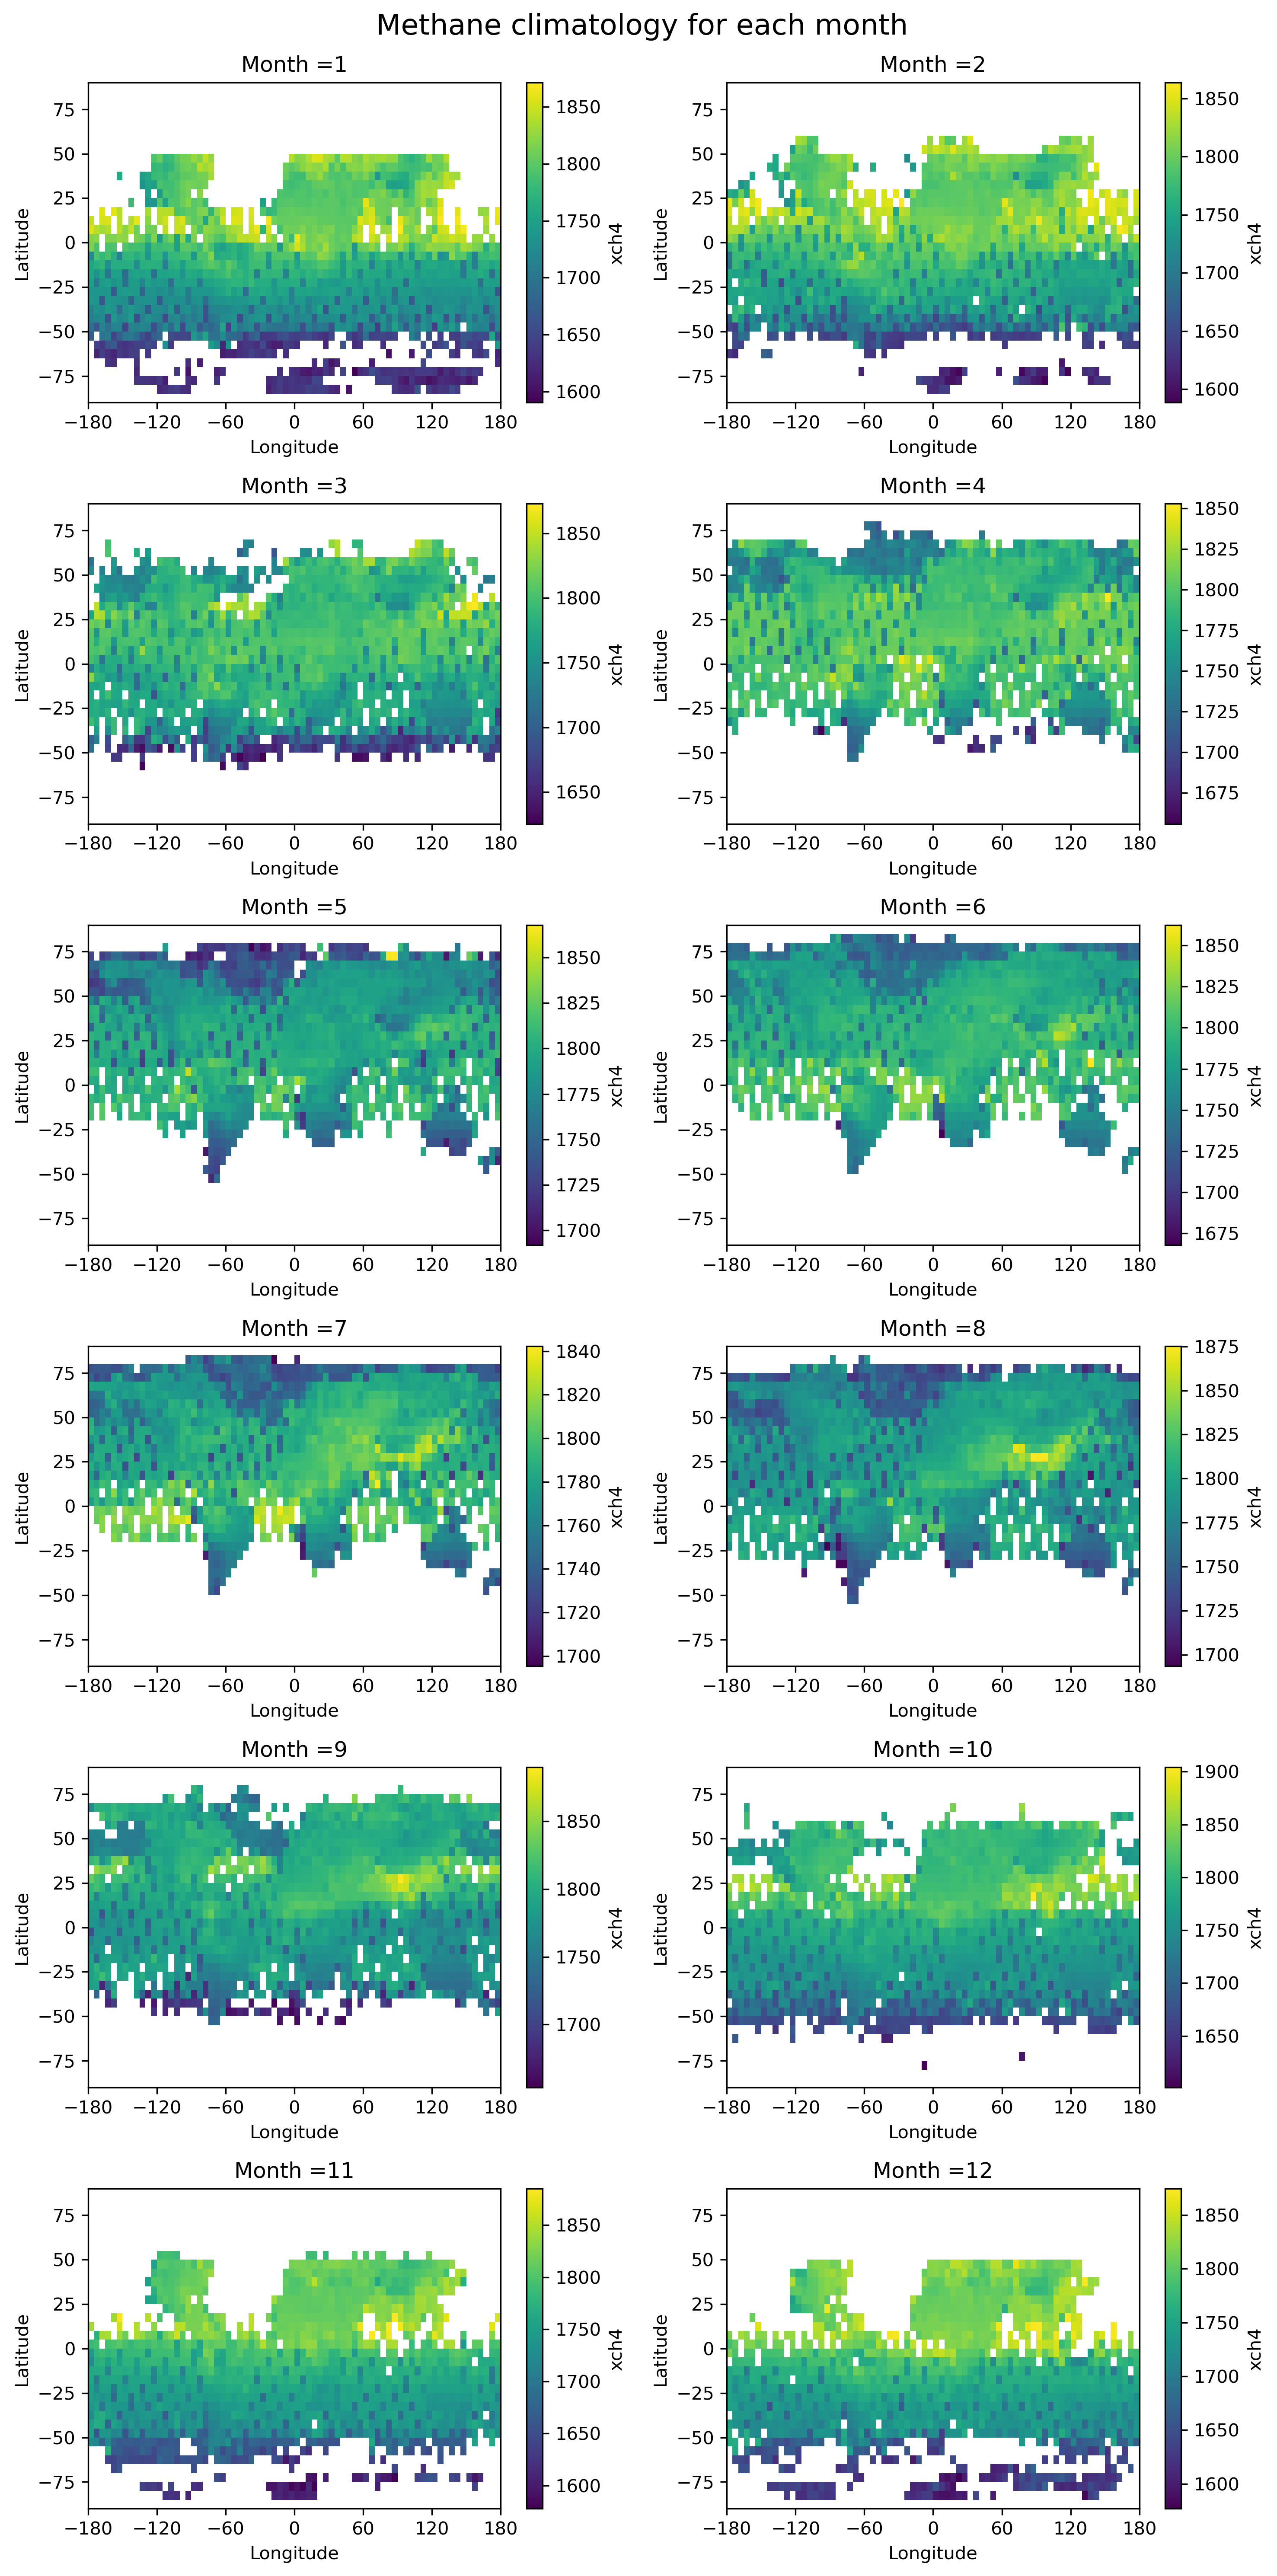

In [2]:
#读取文件命名为Methane
Methane = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc",engine="netcdf4")

#将xch4数据改为ppb浓度
Methane['xch4'].data = Methane['xch4'].data*1e9

#将xch4数据按月平均分辨率提取出来命名为Methane_month
Methane_month = Methane.xch4.groupby('time.month').mean()
plt.figure(figsize=(10,20), dpi=300)

#绘制1-12月xch4含量图
for i in range(1,13):
    #子图显示位置六行两列(6,2,i)
    plt.subplot(6,2,i) 
    Methane_month.sel(month = i).plot()  
    #美化图片
    plt.title('Month ='+ str(i))
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.xticks(range(-180,181,60))
plt.suptitle('Methane climatology for each month', verticalalignment='bottom', fontsize=16) 
plt.tight_layout()
plt.show()

### 1.2 Globally-averaged methane from 2003-01 to 2020-06

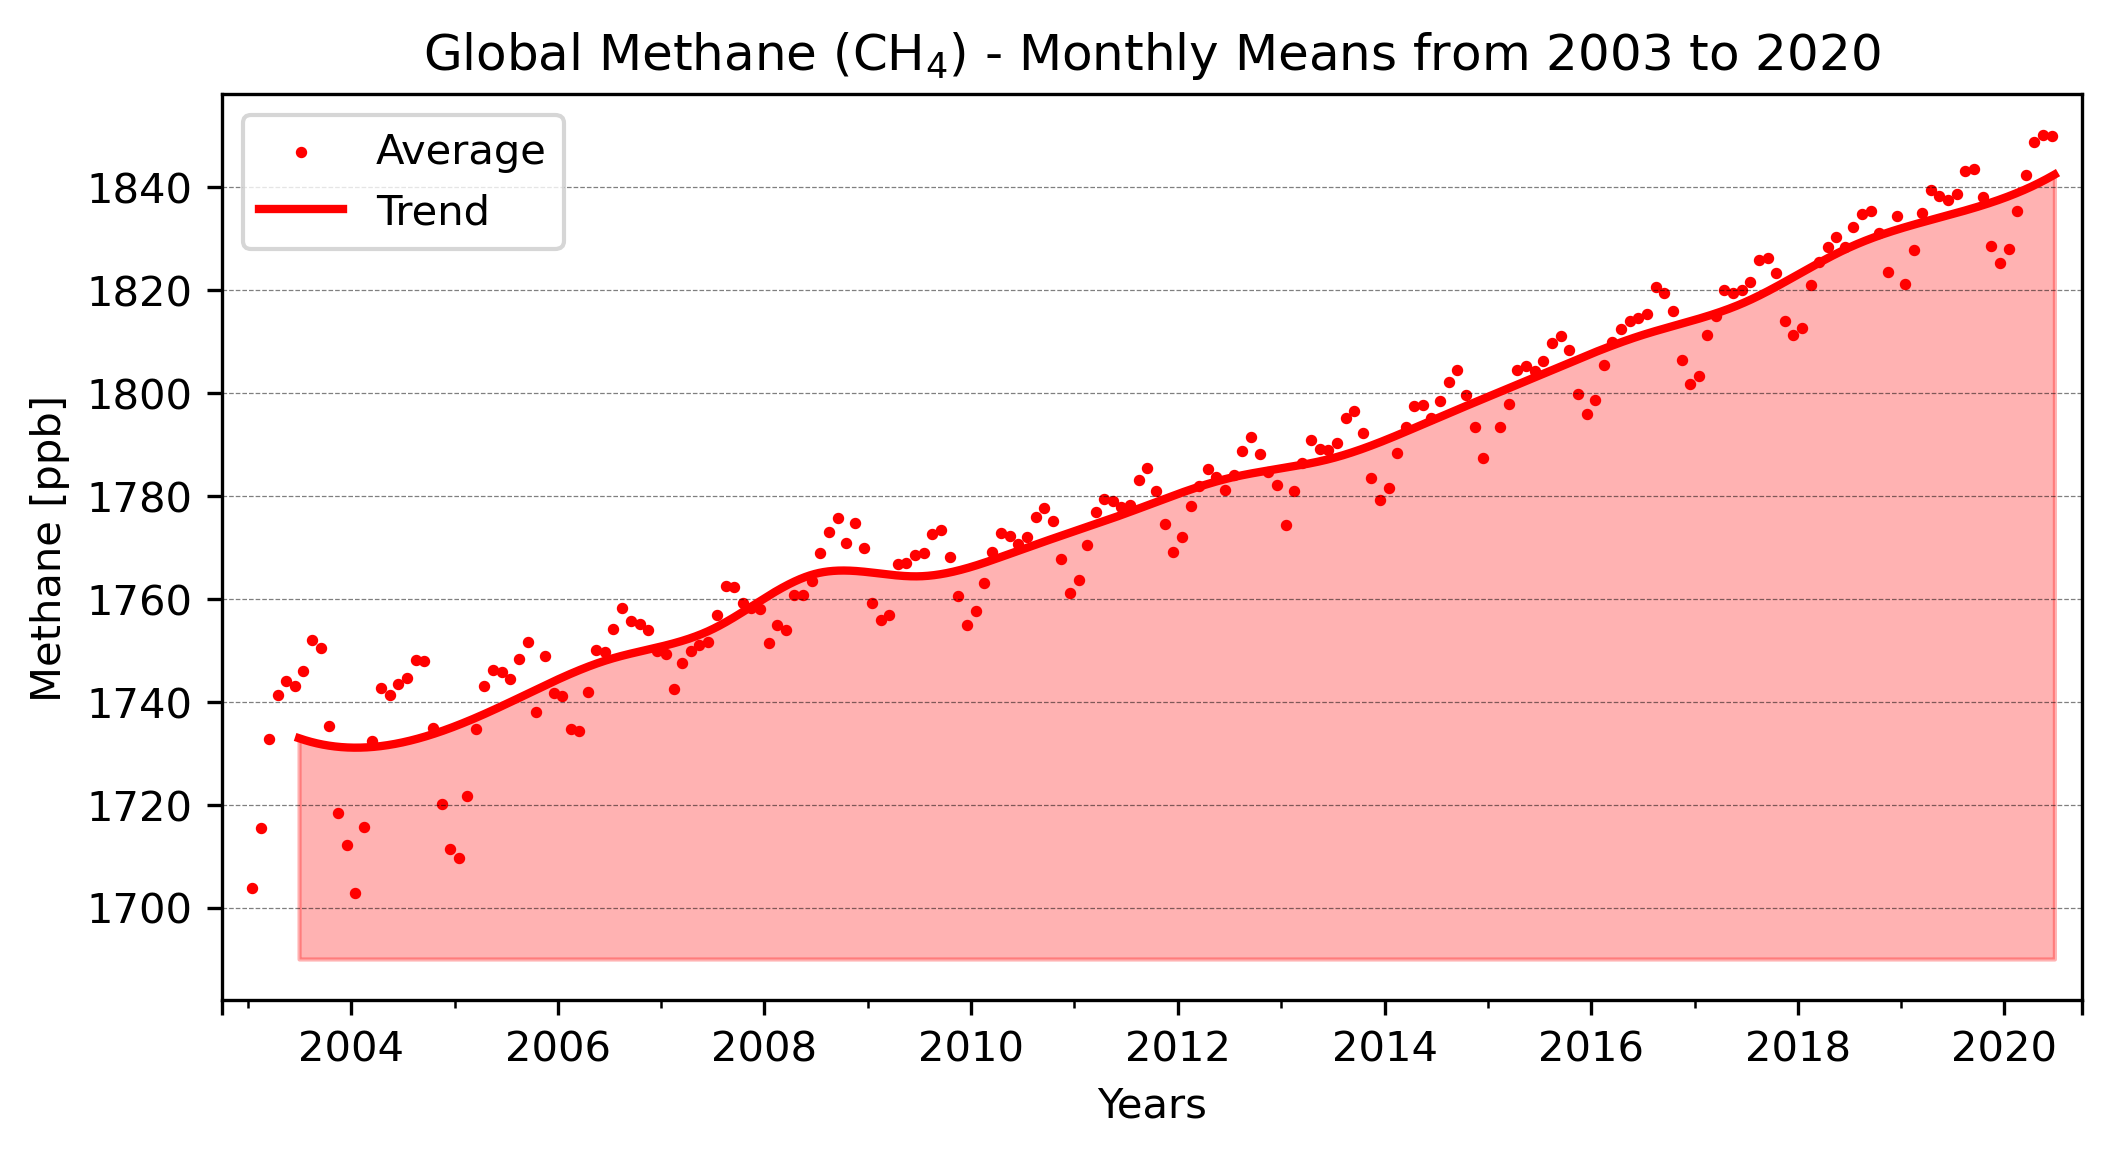

In [3]:
#将全球数据按时间（time）统计起来，绘制成散点图
fig, axs = plt.subplots(1,1, figsize=(8,4),dpi = 300)

#散点图
x = Methane['time'].data
y=Methane.xch4.mean(dim=['lat', 'lon'])
plt.scatter(x,y,s=3, c='r', marker='o')

#美化图片
plt.legend(labels=["Average"],loc=Methane.xch4.mean(dim=['lat', 'lon']),fontsize=6)  
plt.title('Global Methane (CH$_{4}$) - Monthly Means from 2003 to 2020')
plt.xlabel('Years'); plt.ylabel('Methane [ppb]')

#绘制趋势曲线，在这里我使用年均值数据，因此我先将年均值提取出来
#Methane_month为全球月均值数据（Methane为每月数据）
Methane_month = Methane.mean(dim=['lat', 'lon'])

#将其转化为二维列表数据(time+xch4)
all_Methane_month = pd.DataFrame(index=Methane_month['time'],columns=['xch4'])                      
for i in range(len(all_Methane_month)):
    all_Methane_month['xch4'][i] = Methane_month.xch4.values[i]

#通过resample函数实现对每年（Y）的重采样
Methane_Year = all_Methane_month.resample('Y').mean()['xch4']

#绘制趋势曲线(该方法为在百度搜索得到)
#数据起始，从年中开始
startDate ='2003-07-01' 
endDate = '2020-07-01'

#将年均数据新建为df_trend列表
df_trend = pd.DataFrame (Methane_Year.values,index=pd.date_range(startDate,endDate,freq='365D'), columns=['xch4'])

#运用pandas自带的插值函数interpolate，以频率为1天，方法为立方（cubic），对数据进行平滑
df_smooth = df_trend.reindex(index= pd.date_range(startDate, endDate, freq='1D')).interpolate('cubic') 

#将xch4列重命名为Trend,图例
df_smooth = df_smooth.rename(columns={'xch4': 'Trend'})

#绘制曲线图
df_smooth.plot(ax=axs,c = 'r',linewidth=2)

#趋势线下填充红色
axs.fill_between(x = df_smooth.index, y1 = 1690, y2 = df_smooth.values.reshape(-1,), color = 'r',alpha = 0.3)

axs.set_xlim('2002-10-01','2020-10-01')

#网格
axs.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k',axis='y')

#同时，还可以使用课堂上讲的rolling means方法进行重采样，在此不再重复~


### 1.3 Deseasonalized methane levels at point [15°S, 150°W] from 2003-01 to 2020-06

C:\Users\Administrator\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\Administrator\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


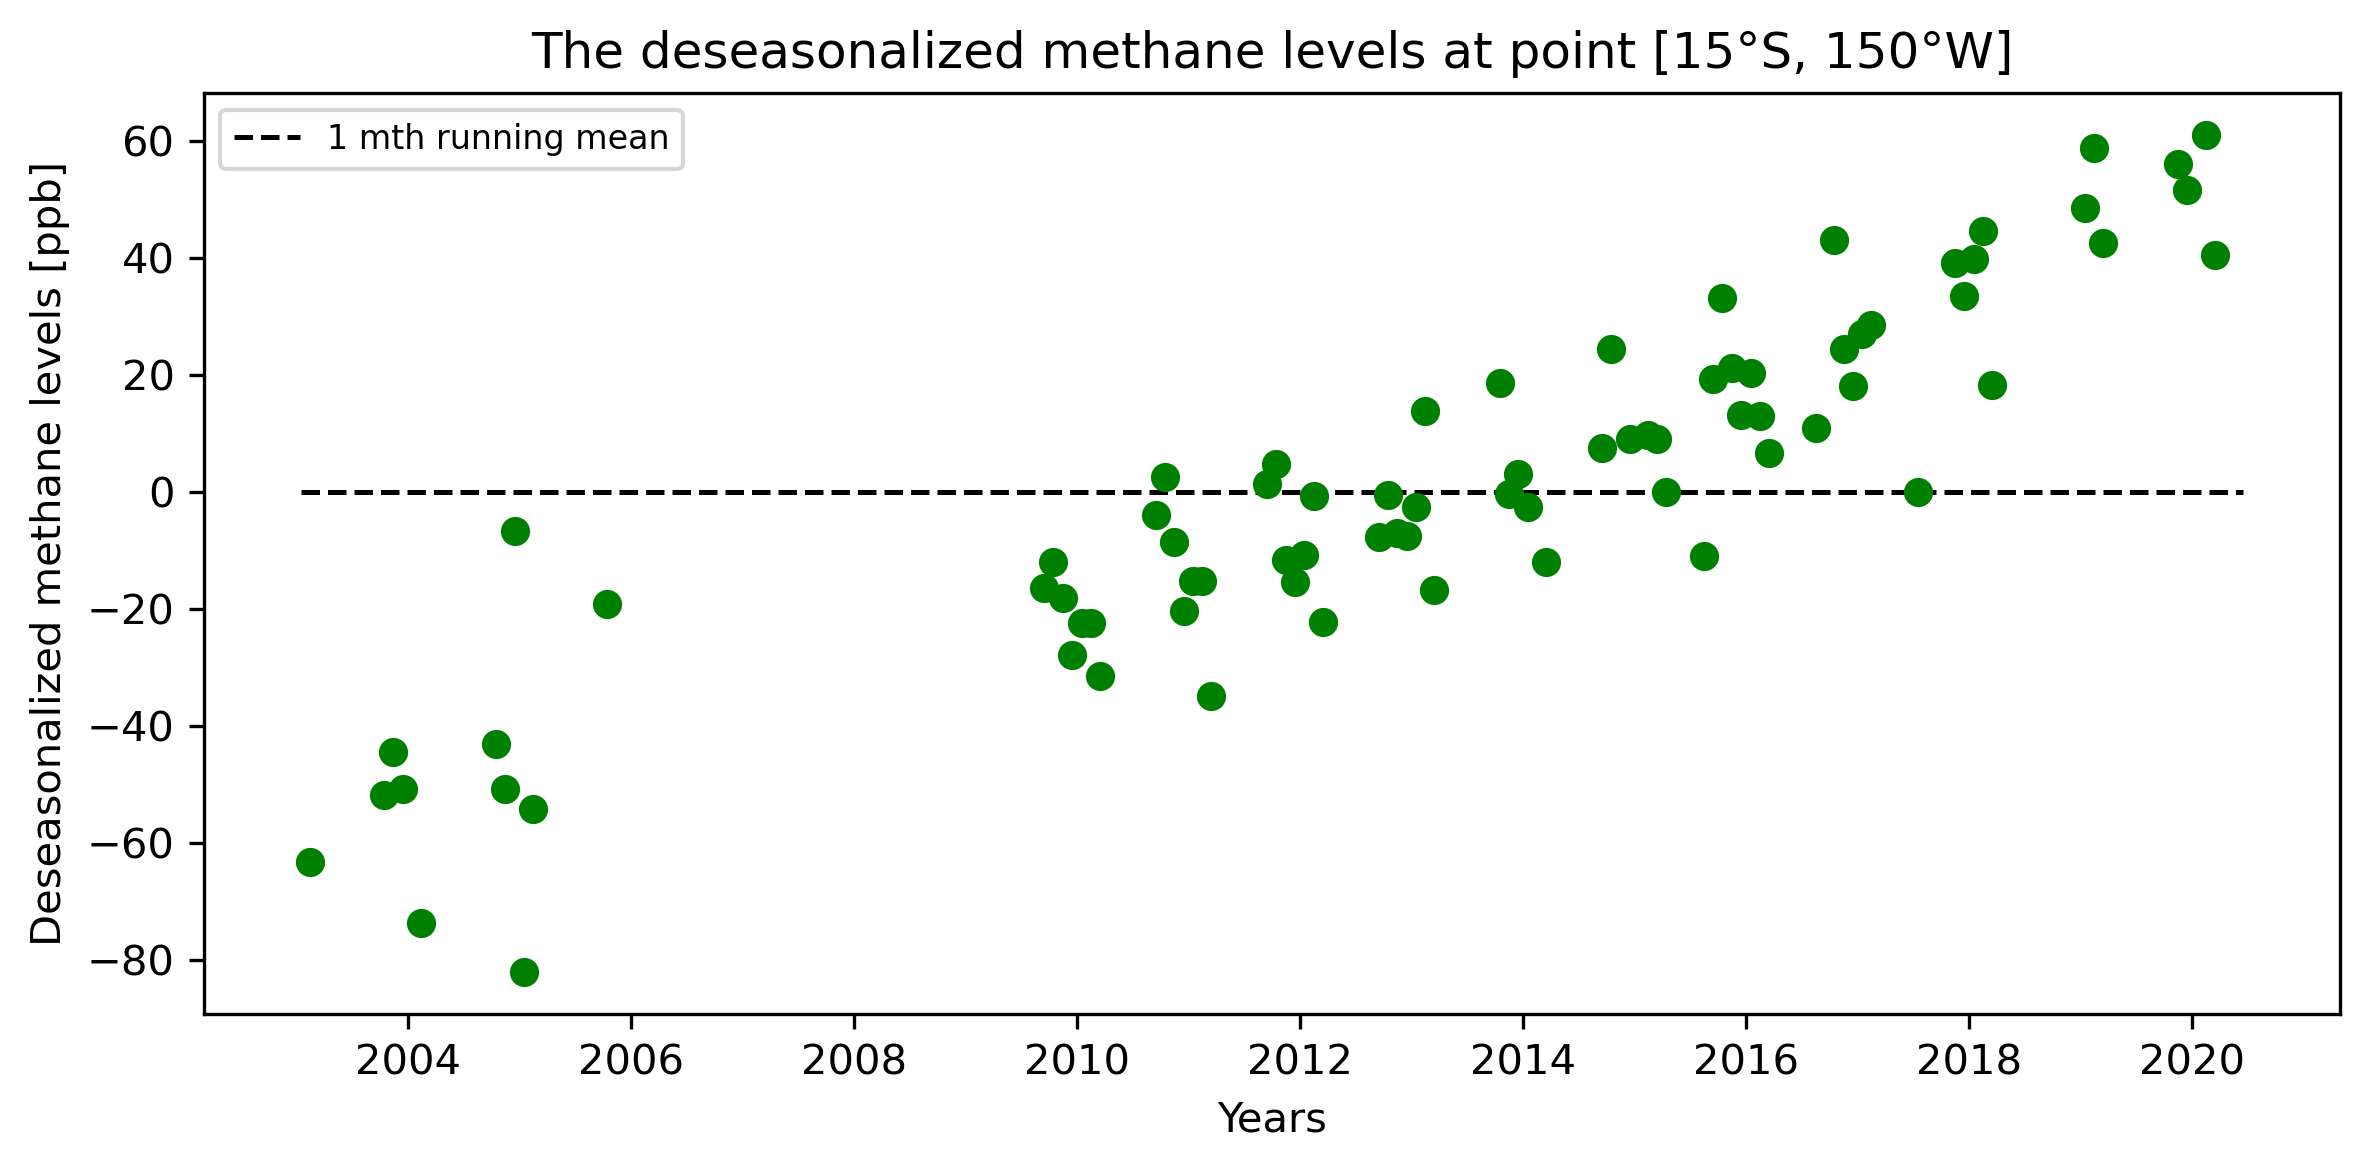

In [4]:
#挑选point [15°S, 150°W]区域
Methane_region = Methane.sel(lat=-15,lon=-150,method='nearest')

#将time数据以月份分组统计（group）
Methane_month = Methane_region.xch4.groupby('time.month')

#每月数据减去气候学数据即为该区域的异常值
#Methane_month.mean(dim = 'time')为2003-2020年每月某地方的sst平均值
Methane_anom = Methane_month - Methane_month.mean(dim = 'time')
fig,axm = plt.subplots(1,1,figsize = [8,4],dpi=300)

#将数据导入到图
axm.hlines(y = 0,xmin=Methane_anom['time'][0],xmax=Methane_anom['time'][-1],color='k',ls='--',
           lw=1.2,label='1 mth running mean')
axm.plot(Methane_anom['time'],Methane_anom.values,'go')

axm.set_title('The deseasonalized methane levels at point [15°S, 150°W]')
axm.set_xlabel('Years')
axm.set_ylabel('Deseasonalized methane levels [ppb]')
axm.legend(loc='best',fontsize=8)

#使用紧凑的布局
plt.tight_layout()
plt.show()

#下方warning有点不懂

### 从数据（去季节性）散点分布我们可以发现：①数据在2006-2010中有缺失，可能与地点以及数据采集方式有关；②在大约2006年之前，甲烷水平是相对较低的，而2010年之后，甲烷水平相对较高；③从2003-2021年甲烷总体水平是呈逐年增高的趋势（2006年之前增高相对缓慢），说明甲烷排放量逐年增大，这可能与人类活动有关，或与整个生态环境的改变有关。

## 2. Niño 3.4 index

### 2.1 Monthly climatology for SST from Niño 3.4 region

In [5]:
#读取文件，命名为SST_data
SST_data = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc",engine="netcdf4")

#挑选the South American coast(5N-5S, 170W-120W)区域
SST_region = SST_data.sel(lat = slice(-5,5), lon = slice(190,240))

#将time数据以月份分组统计（group）
SST_month = SST_region.sst.groupby('time.month')

#每月数据减去气候学数据即为该区域的异常值（SST_anom还是个三维数据，有时间，纬度，经度三个方向）
#SST_month.mean(dim = 'time')为1960-2016年每月某地方的sst平均值
SST_anom = SST_month - SST_month.mean(dim = 'time')


### 2.2 Visualize the computed Niño 3.4

In [6]:
#np.nanmean为沿指定轴计算算术平均值，忽略NaN（在百度中查找到）
#因为SST_anom为三维，方向分别为0：时间，1：纬度，2：经度
#因此我们沿着axis=(1,2)将异常值进行平均计算，得到整个区域在不同时间段的异常数据（SST_anom_average）
SST_anom_average = np.nanmean(SST_anom.values,axis=(1,2))

#转化为二维列表，方便后续用pandas统计画图
#新建一个列表all_data_month，index为时间,columns为异常值
all_data_month = pd.DataFrame(index=SST_anom['time'],columns=['Anomaly'])                      

#将区域异常数据SST_anom_average赋值到all_data_month
for i in range(len(all_data_month)):
    all_data_month['Anomaly'][i] = SST_anom_average[i]

#通过resample函数实现对每3个月（3M）的重采样
SST_3M = all_data_month.resample('3M').mean()['Anomaly']

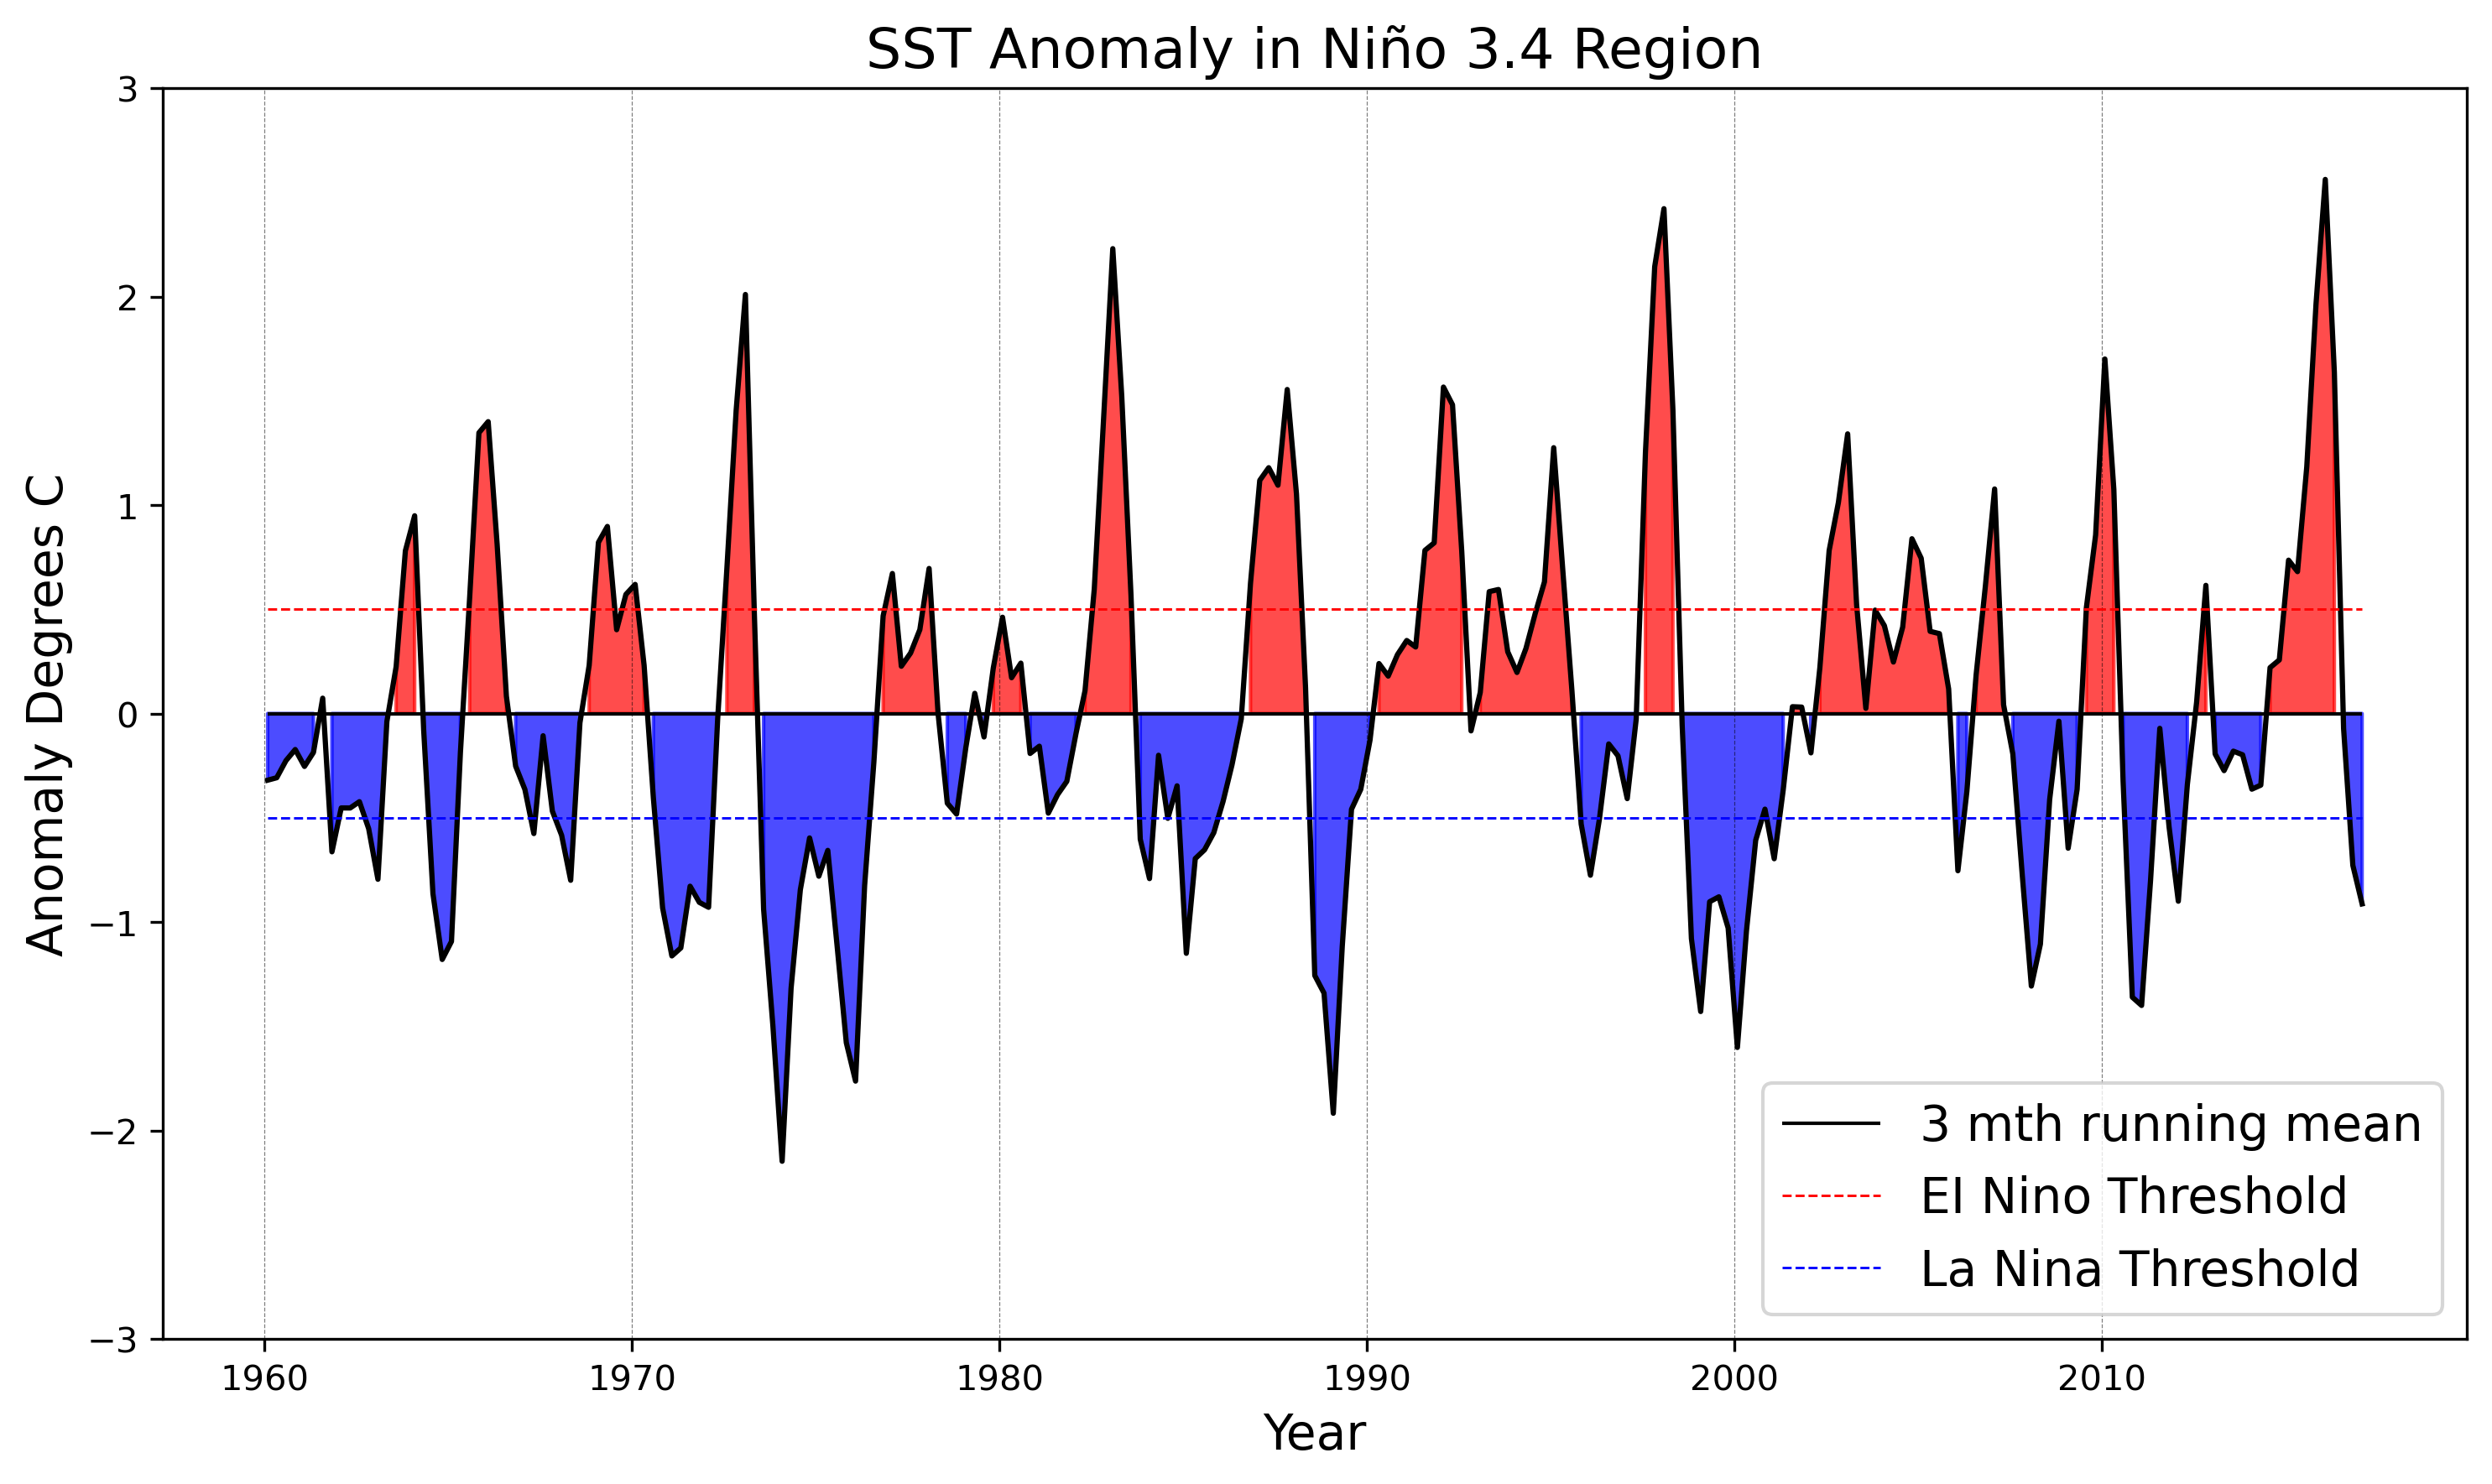

In [7]:
#创建图，大小，分辨率
fig,axs = plt.subplots(1,1,figsize = [10,6],dpi=300)

#将数据导入到图
axs.plot(SST_3M.index,SST_3M.values,color='k')

# 绘制网格线
axs.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k',axis='x')

# 在图中指定位置画线（+/- 0.5°C）
axs.hlines(y = 0,xmin=SST_3M.index[0],xmax=SST_3M.index[-1],color='k',ls='solid',lw=1,label='3 mth running mean')
axs.hlines(y = 0.5,xmin=SST_3M.index[0],xmax=SST_3M.index[-1],color='r',ls='--',lw=0.7,label='EI Nino Threshold')
axs.hlines(y = -0.5,xmin=SST_3M.index[0],xmax=SST_3M.index[-1],color='b',ls='--',lw=0.7,label='La Nina Threshold')

# El Niño 和 La Niña地方填充颜色
axs.fill_between(SST_3M.index,0,SST_3M.values,where=(SST_3M.values>0),color='r',alpha=0.7)
axs.fill_between(SST_3M.index,0,SST_3M.values,where=(SST_3M.values<0),color='b',alpha=0.7)

# x,y轴范围
axs.set_ylim(-3,3)


# 添加图例
axs.legend(loc='best',fontsize=14)

# 设置x,y轴和tile格式
axs.set_xlabel('Year', color='k', fontsize=14)
axs.set_ylabel('Anomaly Degrees C', color='k', fontsize=14)
axs.set_title("SST Anomaly in Niño 3.4 Region", color='k',fontsize=16)

#使用紧凑的布局
plt.tight_layout()
plt.show()

## 3. Explore a netCDF dataset

### 3.1

In [8]:
wind_data = xr.open_dataset("wind_CMFD_V0106_B-01_01dy_010deg_201801-201812.nc",engine="netcdf4")

#将time数据按月份分组统计（group）
wind_month = wind_data.wind.groupby('time.month')

#每日数据减去气候学数据即为该区域的日异常值(每天值-月平均值)
wind_anom = wind_month - wind_month.mean(dim = 'time')

#因为wind_anom为三维，方向分别为0：时间，1：纬度，2：经度
#因此我们沿着axis=(1,2)将异常值进行平均计算，得到整个区域在不同时间段的异常数据（wind_anom_average）
wind_anom_average = np.nanmean(wind_anom.values,axis=(1,2))

#转化为二维列表，方便后续用pandas统计画图
#新建一个列表allwind_data_month，index为时间,columns为异常值
allwind_data_month = pd.DataFrame(index=wind_anom['time'],columns=['Anomaly'])                      

#将区域异常数据wind_anom_average赋值到allwind_data_month
for i in range(len(allwind_data_month)):
    allwind_data_month['Anomaly'][i] = wind_anom_average[i]


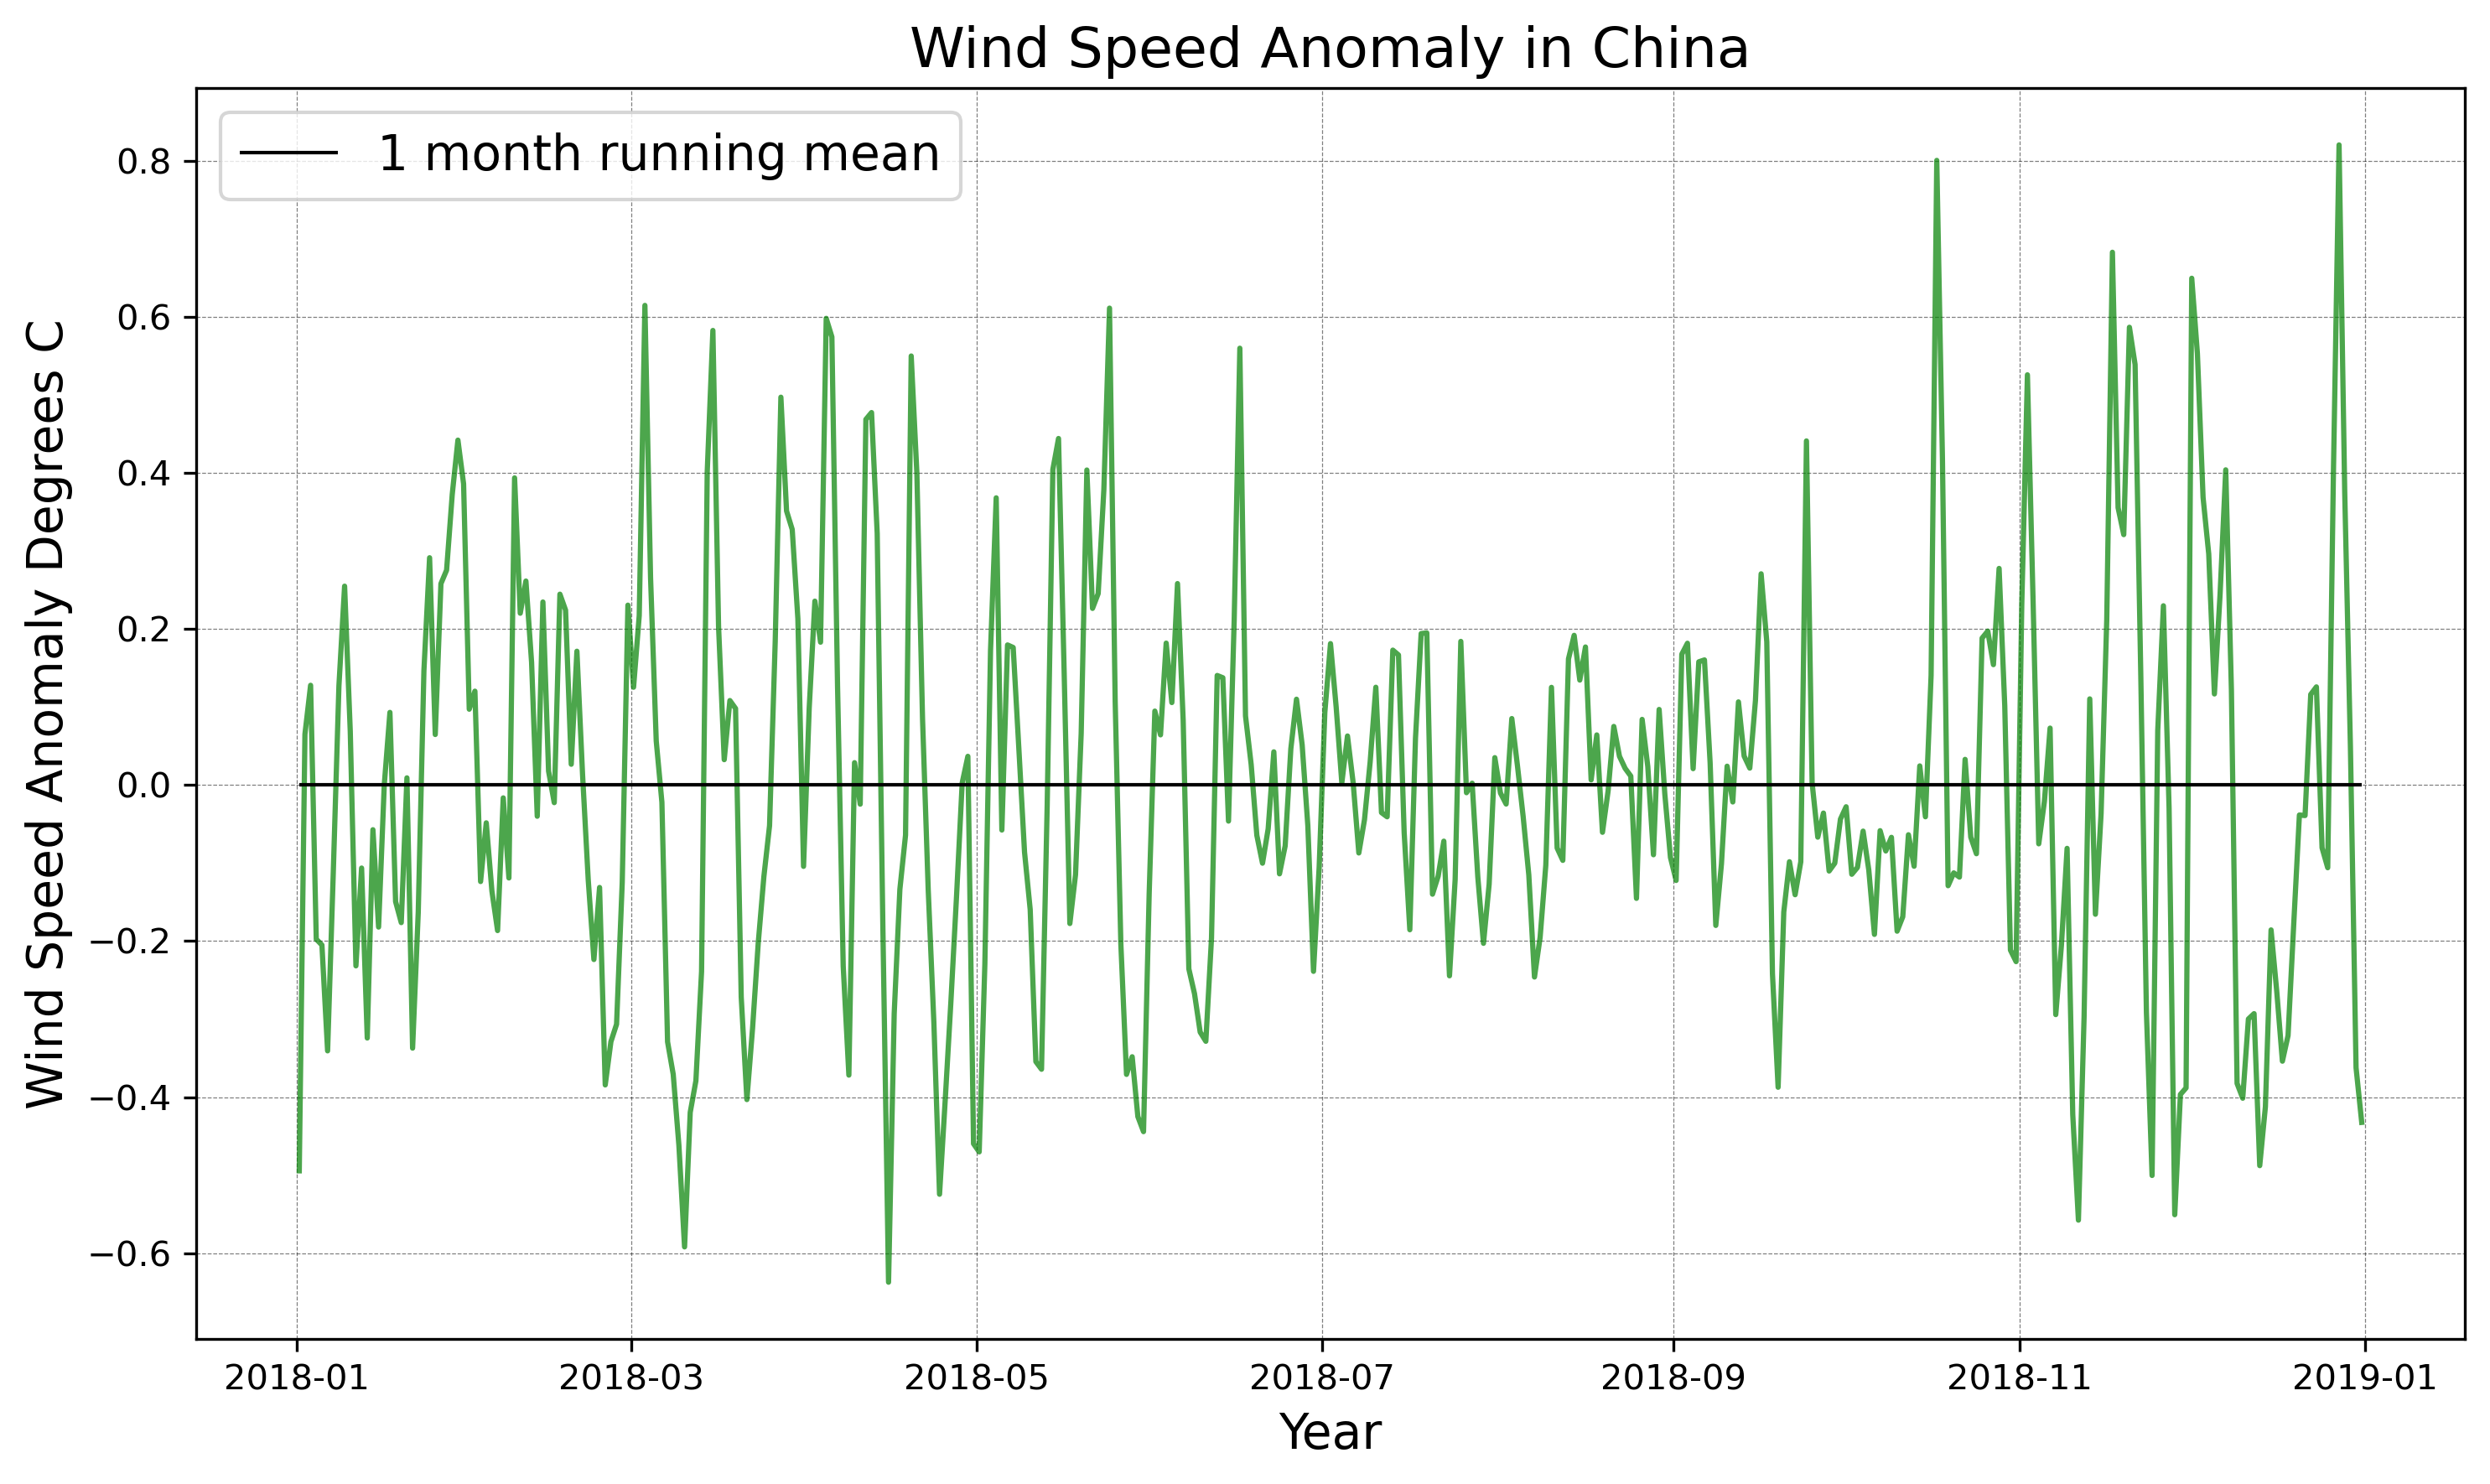

In [9]:
#创建图，大小，分辨率
fig,axw = plt.subplots(1,1,figsize = [10,6],dpi=300)

#将数据导入到图
axw.plot(allwind_data_month.index,allwind_data_month.values,color='g',alpha=0.7)

# 绘制网格线
axw.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')


#在图中y=0画线(每y月均值)
axw.hlines(y = 0,xmin=allwind_data_month.index[0],xmax=allwind_data_month.index[-1],
           color='k',ls='solid',lw=1,label='1 month running mean')

# 添加图例
axw.legend(loc='best',fontsize=14)

# 设置x,y轴和tile格式
axw.set_xlabel('Year', color='k', fontsize=14)
axw.set_ylabel('Wind Speed Anomaly Degrees C', color='k', fontsize=14)
axw.set_title("Wind Speed Anomaly in China", color='k',fontsize=16)

#使用紧凑的布局
plt.tight_layout()
plt.show()

### 3.2

C:\Users\Administrator\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\Administrator\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


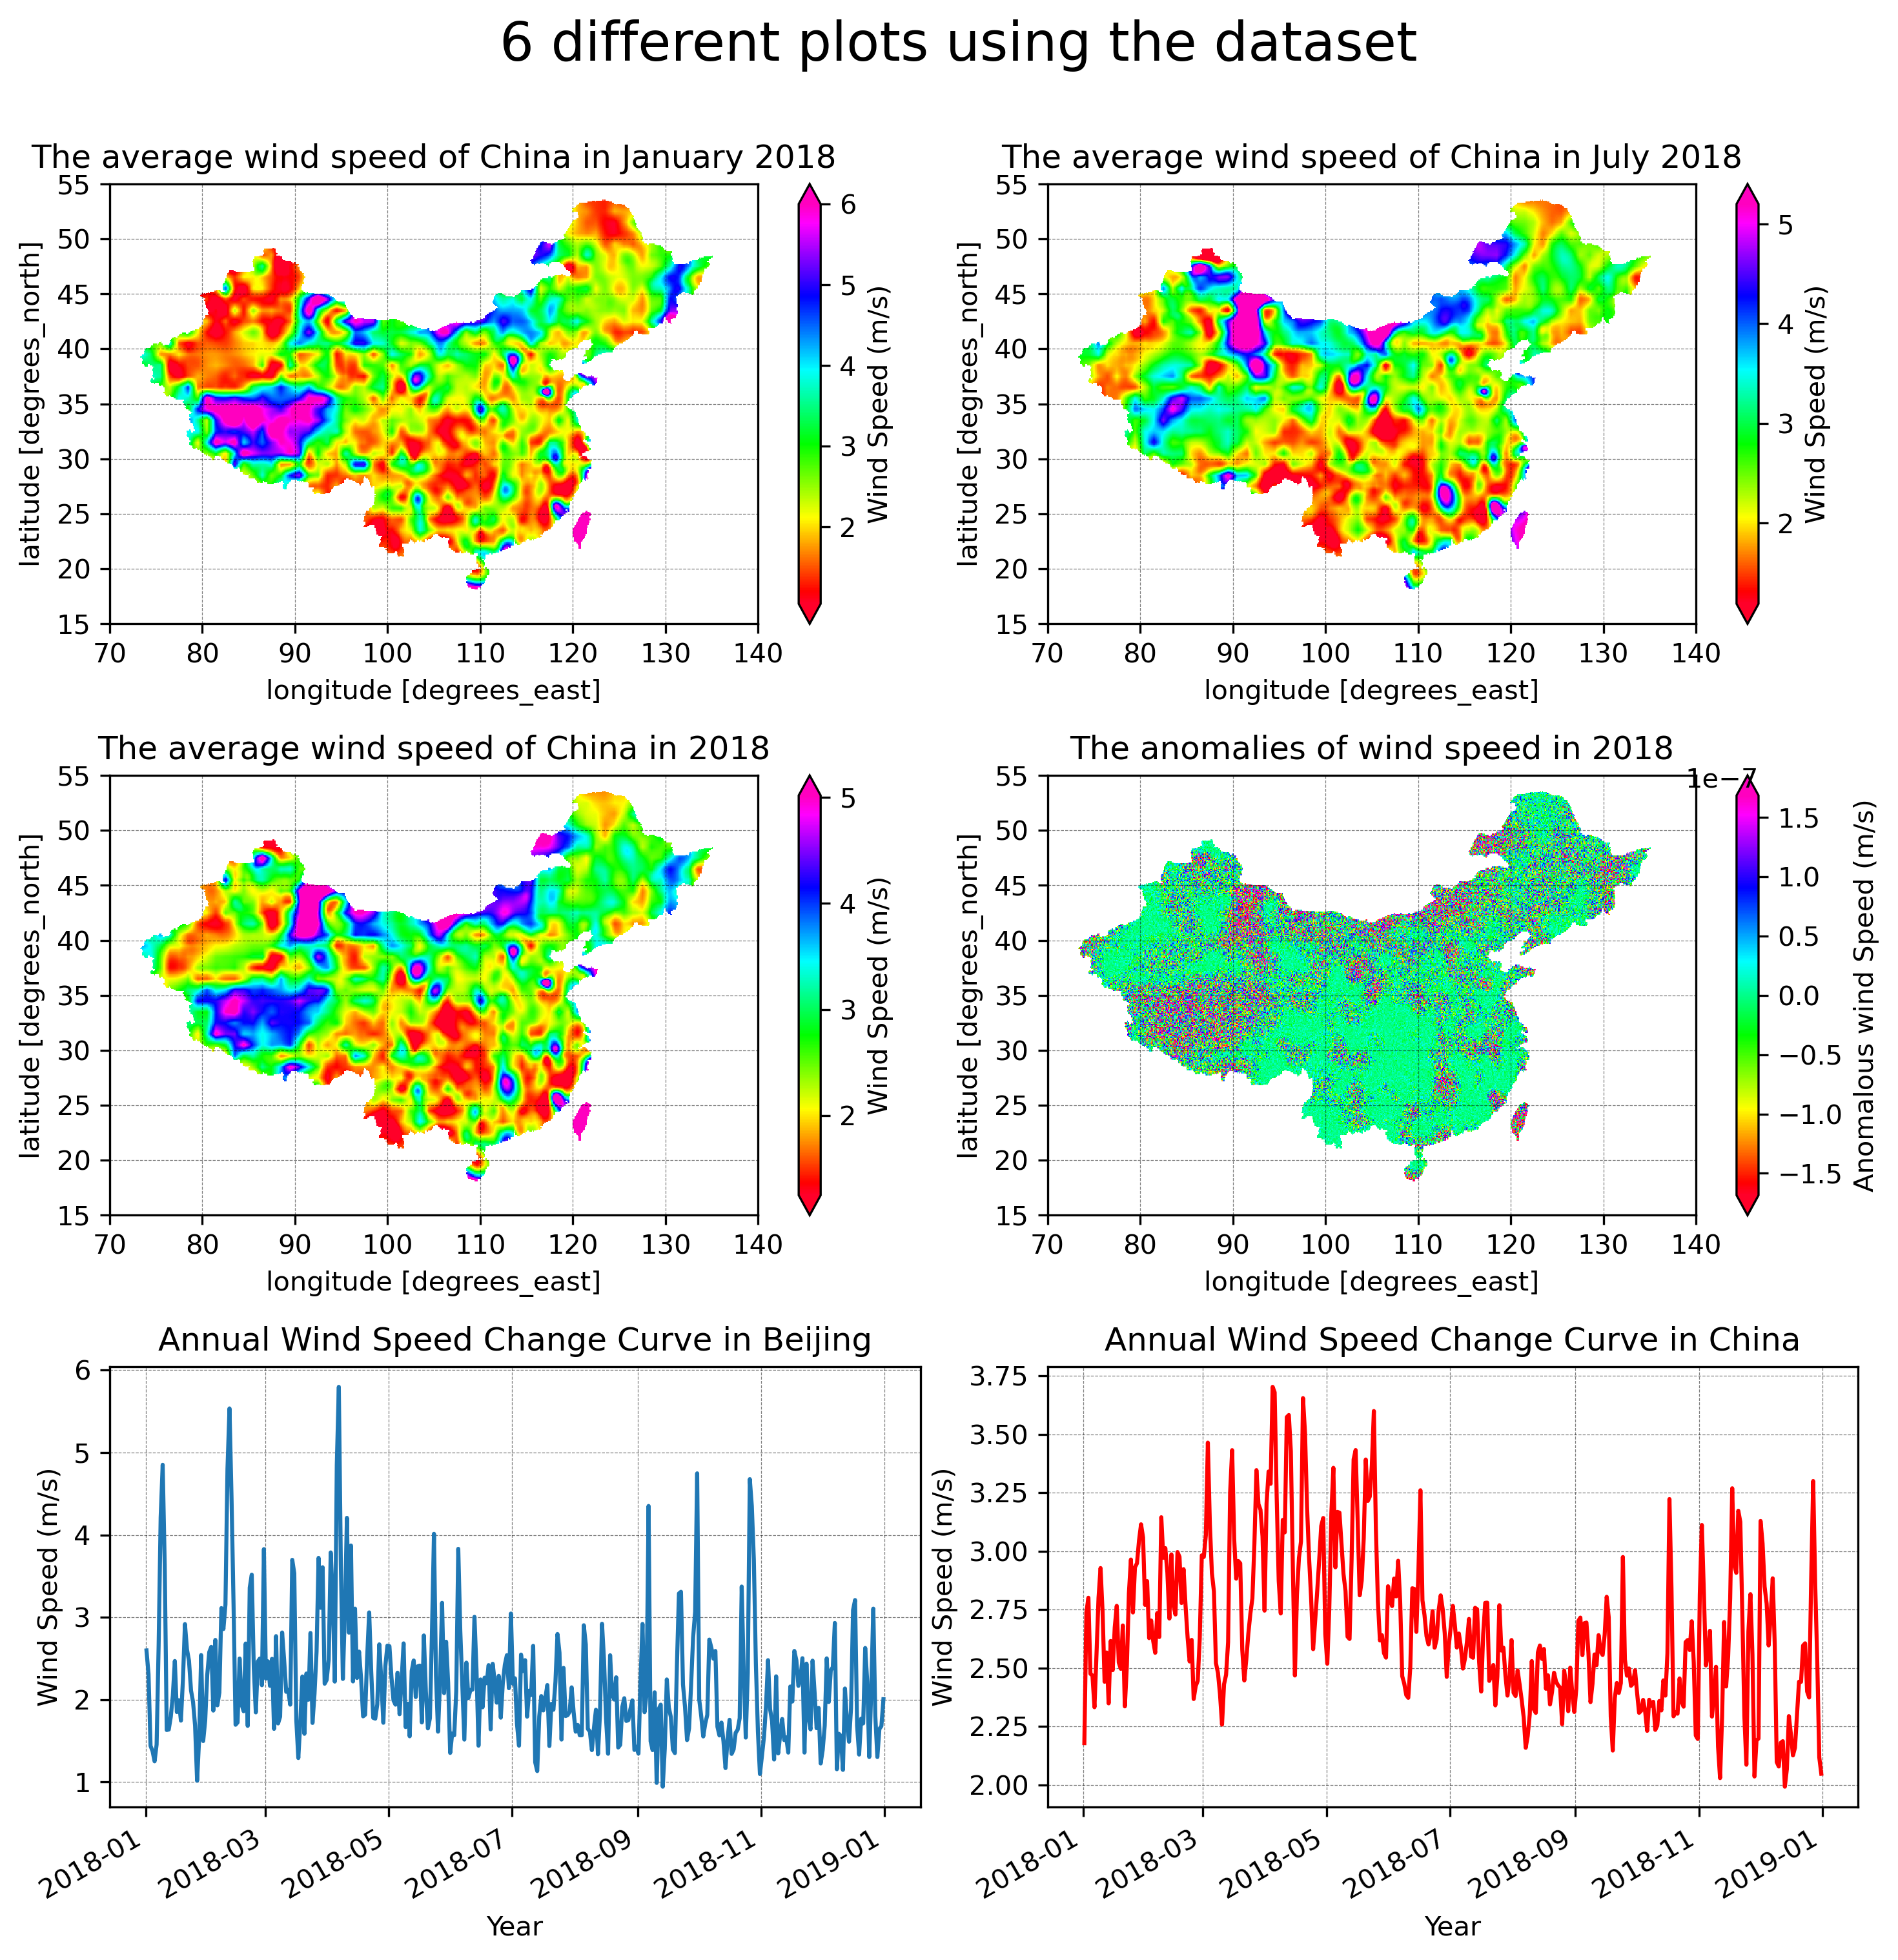

In [10]:
plt.figure(figsize=(10,10),dpi=300)
#中国2018年1月平均风速
plt.subplot(3,2,1) 
wind_data_Jan = wind_data.sel(time = slice('2018-01-01','2018-01-31'))
wind_data_Jan['wind'].mean(dim='time').plot(robust=True,cmap='gist_rainbow',cbar_kwargs={'label':'Wind Speed (m/s)'})  
plt.title('The average wind speed of China in January 2018')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

#中国2018年7月平均风速
plt.subplot(3,2,2)
wind_data_Jul = wind_data.sel(time = slice('2018-07-01','2018-07-31'))
wind_data_Jul['wind'].mean(dim='time').plot(robust=True,cmap='gist_rainbow',cbar_kwargs={'label':'Wind Speed (m/s)'})  
plt.title('The average wind speed of China in July 2018')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

#2018年中国平均风速
plt.subplot(3,2,3)
wind_data['wind'].mean(dim='time').plot(robust=True,cmap='gist_rainbow',cbar_kwargs={'label':'Wind Speed (m/s)'})  
plt.title('The average wind speed of China in 2018')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

#2018年中国区域风速异常
plt.subplot(3,2,4)
wind_anom.mean(dim='time').plot(robust=True,cmap='gist_rainbow',cbar_kwargs={'label':'Anomalous wind Speed (m/s)'})  
plt.title('The anomalies of wind speed in 2018')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

#北京市2018年风速变化曲线
plt.subplot(3,2,5)
wind_data_beijing = wind_data.wind.sel(lat= '39',lon='115',method='nearest')
wind_data_beijing.plot()  
plt.xlabel('Year'); plt.ylabel('Wind Speed (m/s)')
plt.title('Annual Wind Speed Change Curve in Beijing')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

#中国2018年风速变化曲线
plt.subplot(3,2,6)
wind_data['wind'].mean(['lat', 'lon']).plot(color='r')
plt.xlabel('Year'); plt.ylabel('Wind Speed (m/s)')
plt.title('Annual Wind Speed Change Curve in China')
plt.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

plt.suptitle('6 different plots using the dataset', verticalalignment='bottom', fontsize=20) 
plt.tight_layout()
plt.show()

#下方warning不太懂